## Stock Prediction model with Tensorflow 2.0! 

We're going to predict prices of General Electric's stock using a Transformer neural network

## Step 1 - Import data

In [1]:
# https://www.kaggle.com/shujian/transformer-with-lstm

import random, os, sys
import seaborn as sns
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.enable_eager_execution() 
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()
from tensorflow.python.keras.layers import Layer

try:
    from dataloader import TokenList, pad_to_longest
except: pass

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
# I got it from https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC

elements = ['len','open','high','low','volume','ema12','ema26','dif','dea','macd','ma5','ma20','va5','va20','ROC','CCI','OBV','RSI','WILLR','MOM','talib_K','talib_D','talib_J','white_noise','IMF1','IMF2','IMF3']

elements = ['dif','ema12','ema26','high','open','new_IMF9']

df = pd.read_csv( r'C:\Users\Daniel\OneDrive\桌面\data1.csv',delimiter=',',usecols=elements)
# elements = ['len','ema12','ema26','OBV','open','IMF7']

# pa = pd.read_csv( r'C:\Users\Daniel\OneDrive\桌面\data1.csv',delimiter=',',usecols=elements)
# df['IMF10'] = pa['IMF5']/10 +df['IMF10']

In [4]:
len(elements)

6

## Step 2 - Data preprocessing 

In [5]:
SEQ_LEN = 5  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?

In [6]:
# 划分训练集 验证集 测试集

times = sorted(df.index.values)  # get the times
last_10pct = sorted(df.index.values)[-int(0.05*len(times))]  # get the last 10% of the times
last_20pct = sorted(df.index.values)[-int(0.1*len(times))]  # get the last 20% of the times

test_df = df[(df.index >= last_10pct)]
validation_df = df[(df.index >= last_20pct) & (df.index < last_10pct)]  
train_df = df[(df.index < last_20pct)]  # now the train_df is all the data up to the last 20%

In [7]:
from collections import deque
import numpy as np
import random

In [8]:
train_data = train_df.values
valid_data = validation_df.values
test_data = test_df.values

In [9]:
train_data.shape

(6602, 6)

In [10]:
#尝试添加噪声
# train_data[:,-1] = train_data[:,-1]+np.array(pa['IMF7'][0:6602])/3
# train_data[:,-1] = train_data[:,-1]+100*np.sin(np.linspace(1, 6602, 6602)/100)
# valid_data[:,-1] = valid_data[:,-1]+ 50*np.sin(np.linspace(1, 367, 367)/200)
# test_data[:,-1] = test_data[:,-1]+ 50*np.sin(np.linspace(1, 366, 366)/100)

In [11]:
yy_train = train_data[:,-1].copy().reshape(-1,1)

In [12]:
yy_train

array([[-722.68015],
       [-722.79895],
       [-722.91822],
       ...,
       [ 284.13645],
       [ 284.51026],
       [ 284.88297]])

In [13]:
train_data.shape

(6602, 6)

In [14]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

In [15]:
# ss_Y = StandardScaler()
ss_Y = MinMaxScaler()

In [16]:
yy_train

array([[-722.68015],
       [-722.79895],
       [-722.91822],
       ...,
       [ 284.13645],
       [ 284.51026],
       [ 284.88297]])

In [17]:
# Train the Scaler with training data and smooth data
smoothing_window_size =1
for di in range(0,2,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

if len(train_data[di+smoothing_window_size:,:]) > 0:
    # You normalize the last bit of remaining data
    scaler.fit(train_data[di+smoothing_window_size:,0:5])
    train_data[di+smoothing_window_size:,0:5] = scaler.transform(train_data[di+smoothing_window_size:,0:5])
    ss_Y.fit(train_data[di+smoothing_window_size:,-1].reshape(-1,1))
    train_data[di+smoothing_window_size:,-1] = ss_Y.transform(train_data[di+smoothing_window_size:,-1].reshape(-1,1)).flatten()

In [18]:
#valid_data,test_data

In [19]:
# Normalize test data and validation data
valid_data1 = scaler.transform(valid_data[:,0:5])
test_data1 = scaler.transform(test_data[:,0:5])
valid_data2 = ss_Y.transform(valid_data[:,-1].reshape(-1,1)).flatten()
test_data2 = ss_Y.transform(test_data[:,-1].reshape(-1,1)).flatten()

valid_data[:,0:5] = valid_data1
valid_data[:,-1] = valid_data2
test_data[:,0:5] = test_data1
test_data[:,-1] = test_data2

In [20]:
# train_data = np.log(train_data)/np.log(10)
# valid_data = np.log(valid_data)/np.log(10)
# test_data = np.log(test_data)/np.log(10)

In [21]:
#valid_data,test_data

In [22]:
X_train, y_train = [], []
n_samples = train_data.shape[0] - SEQ_LEN
for i in range(n_samples):  # 构造滑动窗口
    X_train.append(train_data[i:i + SEQ_LEN, :])
    y_train.append(train_data[i + SEQ_LEN, -1])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [23]:
X_valid, y_valid = [], []
n_samples = valid_data.shape[0] - SEQ_LEN
for i in range(n_samples):  # 构造滑动窗口
    X_valid.append(valid_data[i:i + SEQ_LEN, :])
    y_valid.append(valid_data[i + SEQ_LEN, -1])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [24]:
X_test, y_test = [], []
n_samples = test_data.shape[0] - SEQ_LEN
for i in range(n_samples):  # 构造滑动窗口
    X_test.append(test_data[i:i + SEQ_LEN, :])
    y_test.append(test_data[i + SEQ_LEN, -1])
X_test = np.array(X_test)
y_test = np.array(y_test)

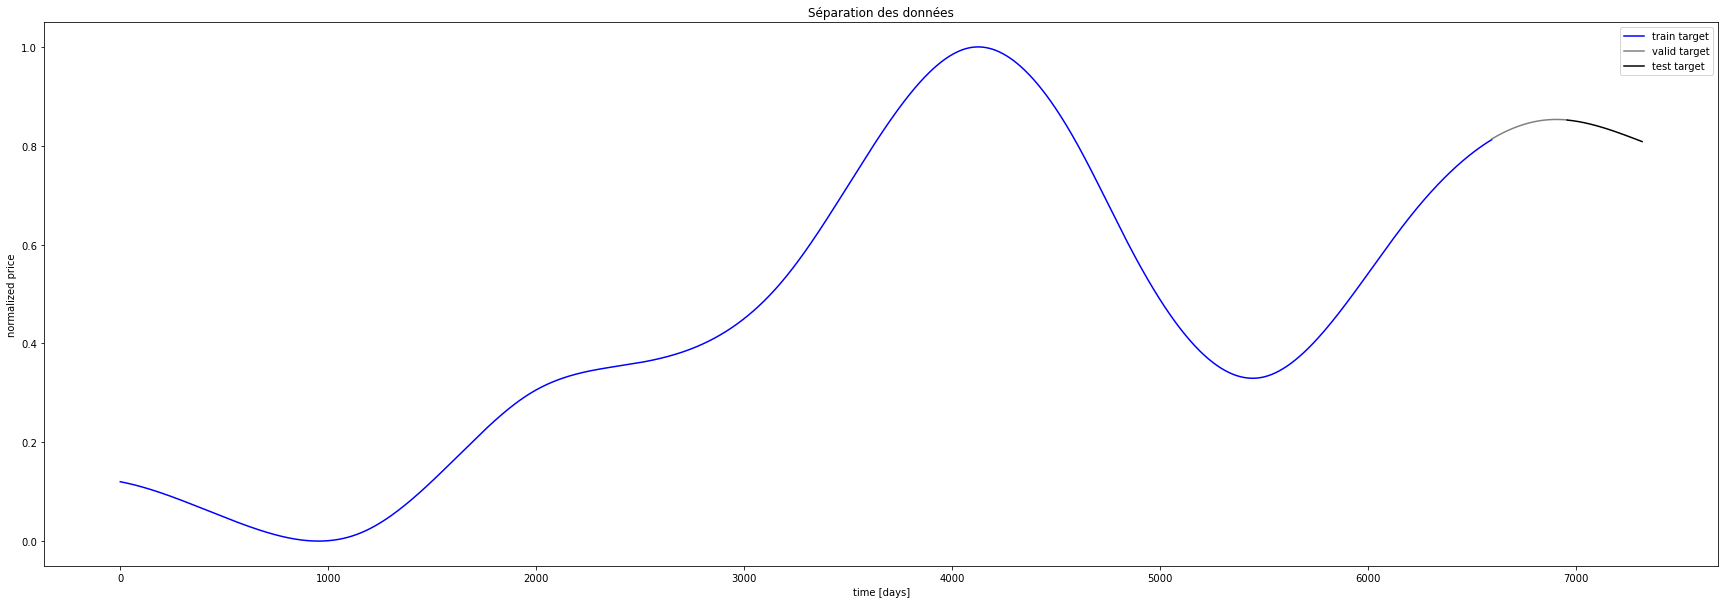

In [25]:
## show predictions
plt.figure(figsize=(30, 10))

plt.plot(np.arange(y_train.shape[0]), y_train, color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid,
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test, color='black', label='test target')


plt.title('Séparation des données')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

In [26]:
# from sklearn.utils import shuffle
# X_train, y_train = shuffle(X_train, y_train)

In [27]:
EPOCHS = 100  # how many passes through our data
BATCH_SIZE = 512  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
import time

NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

# Step 3 - Build our model (The Transformer)


In [28]:
embed_size = 60
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
#         outputs = Add()([outputs, q])
        #outputs = tf.add(outputs, q)#([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

# class EncoderLayer():
#     def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
#         self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
#         self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
#     def __call__(self, enc_input, mask=None):
#         output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
#         output = self.pos_ffn_layer(output)
#         return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask

class Transformer():
    def __init__(self, len_limit, embedding_matrix, d_model=embed_size, \
              d_inner_hid=512, n_head=12, d_k=64, d_v=64, layers=3, dropout=0.1, \
              share_word_emb=False, **kwargs):
        self.name = 'Transformer'
        self.len_limit = len_limit
        self.src_loc_info = False # True # sl: fix later
        self.d_model = d_model
        self.decode_model = None
        d_emb = d_model

        pos_emb = Embedding(len_limit, d_emb, trainable=False, \
                            weights=[GetPosEncodingMatrix(len_limit, d_emb)])

        i_word_emb = Embedding(max_features, d_emb, weights=[embedding_matrix]) # Add Kaggle provided embedding here

        self.encoder = Encoder(d_model, d_inner_hid, n_head, d_k, d_v, layers, dropout, \
                               word_emb=i_word_emb, pos_emb=pos_emb)

        
    def get_pos_seq(self, x):
        mask = K.cast(K.not_equal(x, 0), 'int32')
        pos = K.cumsum(K.ones_like(x, 'int32'), 1)
        return pos * mask

    def compile(self, active_layers=999):
        src_seq_input = Input(shape=(None, ))
        x = Embedding(max_features, embed_size, weights=[embedding_matrix])(src_seq_input)
        
        # LSTM before attention layers
        x = Bidirectional(LSTM(128, return_sequences=True))(x)
        x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
        x, slf_attn = MultiHeadAttention(n_head=3, d_model=300, d_k=64, d_v=64, dropout=0.1)(x, x, x)
        
        avg_pool = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        conc = Dense(64, activation="relu")(conc)
        x = Dense(1, activation="sigmoid")(conc)   
        
        
        self.model = Model(inputs=src_seq_input, outputs=x)
        self.model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])
        
        
    

In [29]:
def build_model():
    inp = Input(shape = (SEQ_LEN, len(elements)))
    
    # LSTM before attention layers
    x = Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Bidirectional(LSTM(64, return_sequences=True))(x) 
        
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=400, d_v=400, dropout=0.2)(x, x, x) #demodel为上一层lstm的2倍        
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(128, activation="relu")(conc)
    
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=400, d_v=400, dropout=0.2)(x, x, x) #demodel为上一层lstm的2倍    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    conc = concatenate([avg_pool, max_pool])
    conc = Dense(64, activation="relu")(conc)
    
#     x, slf_attn = MultiHeadAttention(n_head=1, d_model=128, d_k=64, d_v=64, dropout=0.5)(x, x, x) #demodel为上一层lstm的2倍    
#     avg_pool = GlobalAveragePooling1D()(x)
#     max_pool = GlobalMaxPooling1D()(x)
#     conc = concatenate([avg_pool, max_pool])
#     conc = Dense(64, activation="relu")(conc)
    
    
    conc = Dense(128, activation="relu")(conc)
    x = Dense(1, activation="sigmoid")(conc)  
    

    model = Model(inputs = inp, outputs = x)
    model.compile(
        loss = "mean_squared_error",
#         optimizer = "adam")
#         loss = "mean_squared_error", 
        optimizer = tf.keras.optimizers.Adam() )
#         optimizer = "adam")
    
    # Save entire model to a HDF5 file
     #model.save('GE_stock_price_model.h5')
    
    return model

In [30]:
multi_head = build_model()

In [31]:
multi_head.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 6)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 5, 256)       138240      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 5, 128)      164352      ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 dense (Dense)                  (None, 5, 2000)      256000      ['bidirectional_1[0][0]']    

In [34]:
import keras
keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())

In [ ]:
import time
import datetime

start = time.time()

multi_head.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid), 
                    #callbacks = [checkpoint , lr_reduce]
             )

end = time.time()

elapsed = end - start
print(datetime.timedelta(seconds=elapsed))

Train on 6597 samples, validate on 362 samples
Epoch 1/100
6597/6597 [==============================] - ETA: 0s - loss: 0.1128

D:\anaconda\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6597/6597 [==============================] - 6s 932us/sample - loss: 0.1128 - val_loss: 0.0038
Epoch 2/100
6597/6597 [==============================] - 5s 779us/sample - loss: 0.0106 - val_loss: 0.0073
Epoch 3/100
6597/6597 [==============================] - 5s 761us/sample - loss: 0.0058 - val_loss: 0.0018
Epoch 4/100
6597/6597 [==============================] - 5s 765us/sample - loss: 0.0045 - val_loss: 0.0036
Epoch 5/100
6597/6597 [==============================] - 5s 774us/sample - loss: 0.0037 - val_loss: 0.0043
Epoch 6/100
6597/6597 [==============================] - 5s 771us/sample - loss: 0.0030 - val_loss: 0.0038
Epoch 7/100
6597/6597 [==============================] - 5s 770us/sample - loss: 0.0021 - val_loss: 0.0037
Epoch 8/100
6597/6597 [==============================] - 5s 769us/sample - loss: 0.0014 - val_loss: 0.0034
Epoch 9/100
6597/6597 [==============================] - 5s 769us/sample - loss: 8.3481e-04 - val_loss: 0.0031
Epoch 10/100
6597/6597 [=====================

In [ ]:
model = multi_head

In [ ]:
predicted_stock_price_multi_head = multi_head.predict(X_test)

In [ ]:
predicted_stock_price_multi_head.shape

In [ ]:
predicted_stock_price_multi_head = ss_Y.inverse_transform(predicted_stock_price_multi_head)

In [ ]:
y_test = ss_Y.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# y_test = y_test - np.array(pa['IMF5'][-361:]/10).reshape(-1,1)
# predicted_stock_price_multi_head = predicted_stock_price_multi_head - np.array(pa['IMF5'][-361:]/10).reshape(-1,1)

In [ ]:
plt.figure(figsize = (12,5))
plt.plot(y_test, color = 'r', label = 'true')
plt.plot(predicted_stock_price_multi_head, color = 'b', label = 'predict')
# plt.plot(np.arange(5,773),test_data, color = 'r', label = 'GE Stock Price')
# plt.plot(np.arange(0,733),predicted_stock_price_multi_head, color = 'b', label = 'Predicted GE Close Price')
# plt.title('GE Close Price Prediction', fontsize=30)
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
# plt.xlabel('Date')
# plt.ylabel('GE Close Price')
plt.title('LSTM_Transformer')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

def reg_calculate(test_label1, test_pred1, features=None):


        # mape
        mape = np.mean(np.abs((test_pred1 - test_label1) / test_label1))
        # rmse
        mse = np.sqrt(np.mean(np.square(test_pred1 - test_label1)))
        # mae
        mae = np.mean(np.abs(test_pred1 - test_label1))
        # R2
        r2 = r2_score(test_label1, test_pred1)

        print(
            "mse: {}, mae: {}, mape: {}, r2: {}".format(mse, mae, mape, r2))
        return True


In [ ]:
reg_calculate(y_test[5:-1,:], predicted_stock_price_multi_head[5:-1,:] ,test_data.shape[-1])

In [ ]:
# 准备数据
data = predicted_stock_price_multi_head[5:-1,:].reshape(-1,1)
data_df = pd.DataFrame(data)   #关键1，将ndarray格式转换为DataFrame

# 更改表的索引
data_df.columns = ['pre_imf7_1']  

# 将文件写入excel表格中
writer = pd.ExcelWriter('pre_imf7_1.xlsx')  #关键2，创建名称为hhh的excel表格
data_df.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save()  #关键4

### 